# Setup

In [1]:
import os
import numpy as np
import pickle
import random
from datetime import timedelta
import pandas as pd
from sklearn import cluster, preprocessing, decomposition
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/P5_Segmentez les comportements de clients')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes

In [3]:
SEGMENTS = ['Platinum', 'Gold', 'Silver', 'Bronze']


# Fonctions

In [4]:
def flatten_cols(df):
    """
    Enable to aplanish column names of multi-index dataframe
    """
    temp = df.copy()
    cols = []
    for i, j in temp.columns:
        if j == "":
            j = i
        cols.append(j)
    temp.columns = cols
    return temp

def preprocess_df(df):
    """
    To agregate data from Online Retails data set
    """

    temp = df.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate'])\
             .agg({'StockCode': [('lines', 'count'), \
                                 ('n_pdt', lambda x: len(x.unique()))], \
                   'TotalPrice': [('basket_price', 'sum'), \
                                  ('mean_price', 'mean')], \
                   }).round(2).reset_index()
    temp = flatten_cols(temp)

    temp = temp.groupby('CustomerID')\
               .agg({'InvoiceDate': [\
                                     # récence
                                     ('recency', \
                                      lambda x: (d_study - x.max()).days), \
                                     # durée entre le 1° et le dernier achat
                                     ('duration', \
                                      lambda x: (x.max() - x.min()).days + 1)], \
                     # nb commandes distinctes
                     'InvoiceNo': [('orders', lambda x: len(x.unique()))], \
                     # nombre de produits total achetés par un utilisateur
                     'lines': [('frequency', 'sum'), \
                               # quantité moyenne par transaction
                               ('line_mean', 'mean')], \
                     # nb moyen d'articles différents par achat
                     'n_pdt': [('pdt_mean', 'mean')], \
                     # montant total des commandes
                     'basket_price': [('monetary_value', 'sum')], \
                     # prix moyen des produits achetés par transaction
                     'mean_price': [('price_mean', 'mean')]\
                     }).round(2).reset_index()
    temp = flatten_cols(temp)

    # nb de produits différents achetés par un utilisateur
    pdt = df.groupby('CustomerID')\
            .agg({'StockCode': [('nb_pdt', lambda x: len(x.unique()))]})\
            .reset_index()
    pdt = flatten_cols(pdt)

    return temp.merge(pdt)

def add_rfm(x):
    """
    Return R/F/M values in a string
    """

    return str(x['R']) + str(x['F']) + str(x['M'])

def scoring_RFM(df, n):
    """
    Enable to add R, F, M, RFM_Score et RFM features based on recency,
    frequency and monetary_value features according to their n-quantiles
    """

    r_labels = range(1, n+1)
    f_labels = range(n, 0, -1)
    m_labels = range(n, 0, -1)
    r_quartiles = pd.qcut(df['recency'], q=n, labels=r_labels)
    f_quartiles = pd.qcut(df['frequency'], q=n, labels=f_labels)
    m_quartiles = pd.qcut(df['monetary_value'], q=n, labels=m_labels)
    temp = df.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)
    temp['RFM_Segment'] = temp.apply(add_rfm, axis=1)
    temp['RFM_Score'] = temp[['R', 'F', 'M']].sum(axis=1)
    temp['General_Segment'] = temp.apply(segments, axis=1)
    return temp

def segments(df):
    """
    Customer segmentation as Platinum, Gold, Silver, Bronze based on RFM scores
    """

    seg = ''
    if df['RFM_Score'] == 3:
        seg = SEGMENTS[0]
    elif df['RFM_Score'] < 6:
        seg = SEGMENTS[1]
    elif df['RFM_Score'] <= 9:
        seg = SEGMENTS[2]
    else:
        seg = SEGMENTS[3]

    return seg

def preprocess_RFM(df):
    """
    To agregate customer orders implementing RFM method.
    Recence start date is the day after the latest invoice date.
    """

    temp = df.copy()
    temp['TotalPrice'] = temp['Quantity'] * temp['UnitPrice']
    d_study = temp.InvoiceDate.max() + timedelta(days=1)
    temp = temp.groupby('CustomerID').\
                agg(# récence
                    {'InvoiceDate': [('recency', \
                                      lambda x: (d_study - x.max()).days),
                                     # fréquence
                                     ('frequency', 'count')],
                     # montant total des commandes
                     'TotalPrice': [('monetary_value', 'sum')]
                     }).round(2).reset_index()
    temp.columns = ['CustomerID', 'recency', 'frequency', 'monetary_value']

    return temp

def segment_customers(df):
    """
    Enable to 'labelize' the customers as Platinum/Gold/Silver/Bronze 
    according to their R/F/M values in dataframe df 
    """

    with open('OC_DS_P5.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        clf = unpickler.load()

    temp = preprocess_RFM(df)
    X = temp[['recency', 'frequency', 'monetary_value']]
    X_scaled = preprocessing.StandardScaler().fit_transform(np.log(X))
    temp = temp.assign(Segment=clf.predict(X_scaled) )

    return temp

In [5]:
with open('OC_DS_P5_temp.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    rfm_log = unpickler.load()
    source = unpickler.load()
    rfmTable = unpickler.load()

# Clustering
Je considère à partir d'ici uniquement les variables "R/F/M" car la pertinentce des autres attributs créés n'a pas été avérée lors des itérations précédentes.

Dans un premier temps, les jeux de données d'entrainement et de test sont constitués aléatoirement (resp. 70% et 30% de tous les enregistrements).

Je commence par importer les objets créés en phase  d'exploration.

## PCA

In [6]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(rfm_log[['recency', 'frequency', 'monetary_value']], \
                                     rfmTable.General_Segment, test_size=0.3 )

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2639, 3), (1132, 3))

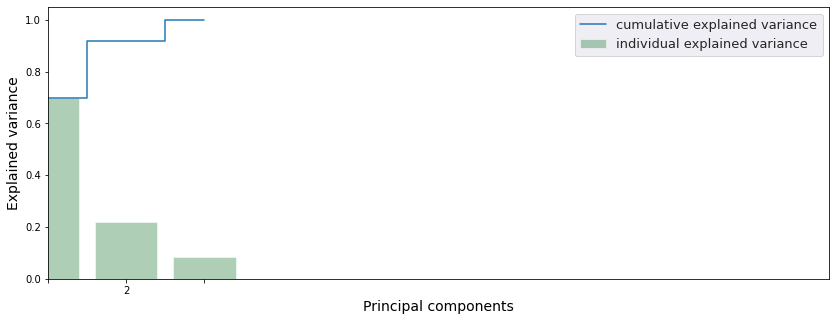

In [7]:
pca = decomposition.PCA()
pca.fit(X_train_scaled)
X_trans = pca.transform(X_train_scaled)

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X_train.shape[1]), pca.explained_variance_ratio_.cumsum(), \
         where='mid', label='cumulative explained variance')
sns.barplot(x=np.arange(1,X_train.shape[1]+1), y=pca.explained_variance_ratio_, \
            alpha=0.5, color = 'g', label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' \
                    for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)

PCA 2 composants: [0.69734903 0.21945866] 0.9168076939614136


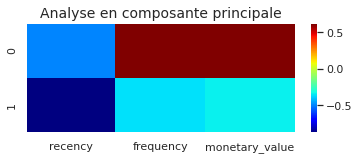

In [8]:
pca = decomposition.PCA(n_components=2)
X_trans = pca.fit_transform(X_train_scaled)
print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

map= pd.DataFrame(pca.components_,columns=X_train.columns)
plt.figure(figsize=(6,2))
plt.title('Analyse en composante principale', fontdict={'fontsize': 14})
sns.heatmap(map, cmap='jet')

(-1.0, -0.0)

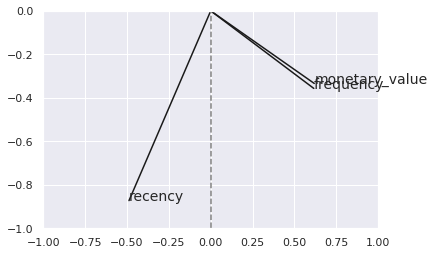

In [9]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0,:], pcs[1,:])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X_train.columns[i], fontsize='14')

minx, maxx = np.floor(min(pcs[0,:])), np.ceil(max(pcs[0,:]))
miny, maxy = np.floor(min(pcs[1,:])), np.ceil(max(pcs[1,:]))

# Afficher une ligne horizontale y=0
plt.plot([minx, maxx], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [miny, maxy], color='grey', ls='--')

plt.xlim([minx, maxx])
plt.ylim([miny, maxy])

## KMeans

best clustering =  2


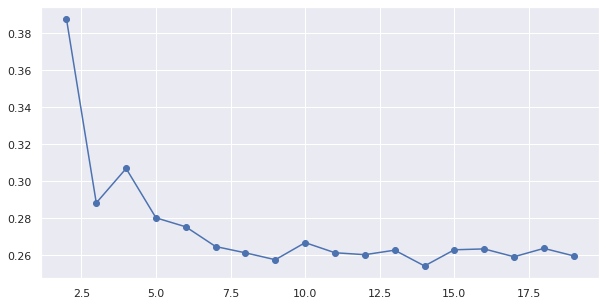

In [10]:
fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(2, 20)
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X_train_scaled)
    silhouettes.append(metrics.silhouette_score(X_train_scaled, myclust.labels_))

plt.plot(cluster_range, silhouettes, marker='o')

best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster)

In [11]:
segment_col = 'General_Segment'
lbl = preprocessing.LabelEncoder()
lbl.fit(rfmTable[segment_col])
lbl.classes_

array(['Bronze', 'Gold', 'Platinum', 'Silver'], dtype=object)

Silhouette Coefficient: 0.307


cluster
0          861
1          833
2          510
3          435
dtype: int64

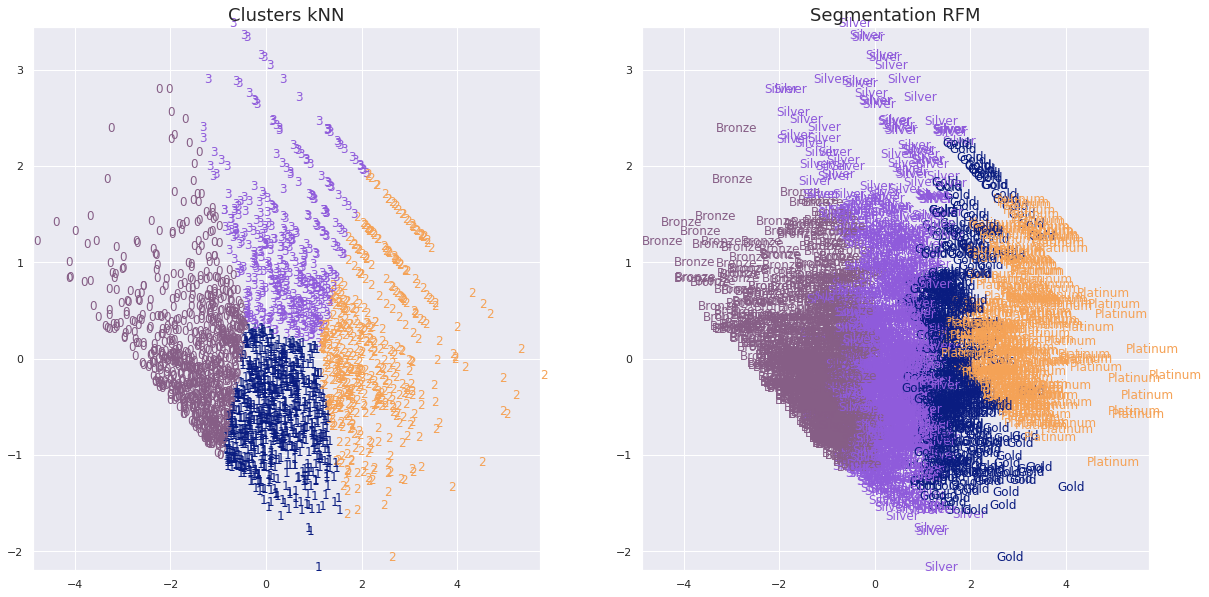

In [12]:
nb_clusters = len(lbl.classes_)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 10))

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_train_scaled)

plt.subplot(121)
# Puis on visualise, selon la méthode donnée dans le coup de pouce:
for i in range(X_trans.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
             color=color[myclust.labels_[i]] )

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.min(X_trans[:, 0]), np.max(X_trans[:, 0]))
plt.ylim(np.min(X_trans[:, 1]), np.max(X_trans[:, 1]))
plt.title("Clusters kNN", fontsize=18)

plt.subplot(122)
# Puis on visualise, selon la méthode donnée dans le coup de pouce:
for i in range(X_trans.shape[0]): # pour chaque point
    #idx = X_train.index[i]
    segment = rfmTable.loc[X_train.index[i], segment_col]
    plt.text(X_trans[i, 0], X_trans[i, 1], segment, \
             color=color[list(lbl.classes_).index(segment)]
             )

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.min(X_trans[:, 0]), np.max(X_trans[:, 0]))
plt.ylim(np.min(X_trans[:, 1]), np.max(X_trans[:, 1]))
plt.title("Segmentation RFM", fontsize=18)

# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_scaled, myclust.labels_))

pd.DataFrame(myclust.labels_, columns=['cluster']).value_counts()

Les groupes aux extrémités (2/Bronze et 1/Platinum) sont cohérents.

L'étiquetage arbitraire des scores RFM doit expliquer les différences présentes sur les 2 groupes centraux.

In [13]:
#Create a cluster label column in the original DataFrame
y_train = myclust.labels_
y_test = myclust.predict(X_test_scaled)

#Calculate average RFM values and size for each cluster:
temp = rfmTable[['recency', 'frequency', 'monetary_value']].\
       merge(X_train.assign(cluster = y_train)['cluster'], \
             left_index=True, right_index=True).\
             groupby(['cluster']).agg(['mean', 'min', 'max']).round(2).\
       sort_values(by=[('monetary_value', 'mean')], \
                   ascending=[False]).round(2).reset_index()
temp

cluster recency           ... frequency monetary_value                   
             mean min  max  ...       max           mean     min        max
0       2   15.65   1  115  ...      7064        5998.11  646.42  231822.69
1       1  105.52  20  333  ...       462        1151.69  155.37   39619.50
2       3   11.93   1   37  ...       169         651.51   80.85    6748.80
3       0  156.05   6  333  ...        58         262.30    3.75    3202.92

[4 rows x 10 columns]

Etiquetage des clusters calculés

In [14]:
dict_rank =  { j: SEGMENTS[i] for i, j in temp['cluster'].to_dict().items()}
print(dict_rank)

y_train_lbl = []
y_test_lbl = []
for i in range(len(y_train)):
    y_train_lbl.append(dict_rank[y_train[i]])
y_train = y_train_lbl
for i in range(len(y_test)):
    y_test_lbl.append(dict_rank[y_test[i]])
y_test = y_test_lbl

{2: 'Platinum', 1: 'Gold', 3: 'Silver', 0: 'Bronze'}


## DBSCAN 
Calculé à titre d'exemple

clusters: 2568
bruit: 71


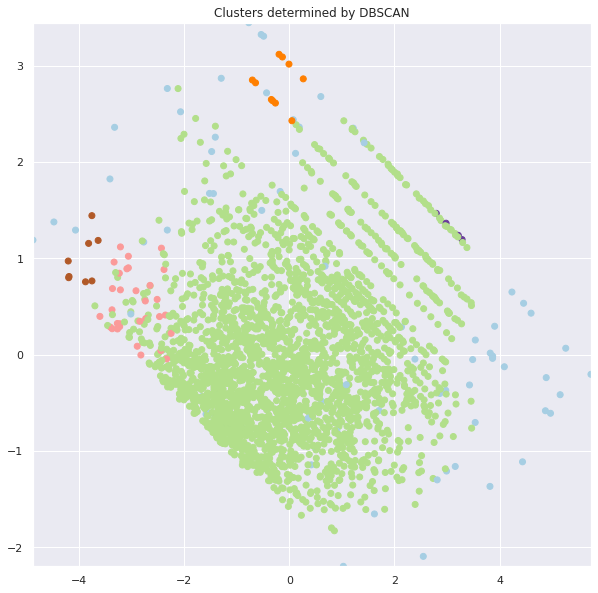

In [15]:
db = DBSCAN(eps=.5, min_samples=5)
db.fit(X_train_scaled)

y_pred = db.fit_predict(X_train_scaled)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_trans[:,0], X_trans[:,1], c=y_pred, cmap='Paired')
plt.xlim(np.min(X_trans[:, 0]), np.max(X_trans[:, 0]))
plt.ylim(np.min(X_trans[:, 1]), np.max(X_trans[:, 1]))

plt.title("Clusters determined by DBSCAN")

print('clusters:', db.labels_[db.labels_ != -1].size)
print('bruit:', db.labels_[db.labels_ == -1].size)

# Classification

In [16]:
DICT_CLF = {'knn': {'name': 'k-Nearest Neighbors',
                     'clf': KNeighborsClassifier(),
                     'params': {'n_neighbors': np.arange(1,50,1)}},
            'svm': {'name': 'Support Vector Machine',
                     'clf': LinearSVC(dual=False, multi_class='ovr') ,
                     'params': {'C': np.logspace(-3, 3, 7),
                                'loss': ['hinge','squared_hinge'],
                                'penalty': ['l1', 'l2']}},
            'rfc': {'name': 'Random Forrest',
                     'clf': RandomForestClassifier(),
                     'params': {'criterion': ['entropy', 'gini'],
                                'n_estimators': [20, 40, 60, 80, 100],
                                'max_features':['sqrt', 'log2']}},
            'adc': {'name': 'AdaBoost',
                     'clf': AdaBoostClassifier(),
                     'params': {'n_estimators': \
                                [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}},
            'gbc': {'name': 'Gradient Boosting',
                     'clf': GradientBoostingClassifier(),
                     'params': {'n_estimators': \
                                [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}}
            }

k-Nearest Neighbors
------------------------------
Best params: {'n_neighbors': 21} 

Precision: 98.00 % 

Confusion matrix, without normalization
[[356   1   0   1]
 [  2 362   0   1]
 [  0   5 219   1]
 [  6   5   3 170]]
Normalized confusion matrix
[[0.99 0.   0.   0.  ]
 [0.01 0.99 0.   0.  ]
 [0.   0.02 0.97 0.  ]
 [0.03 0.03 0.02 0.92]]


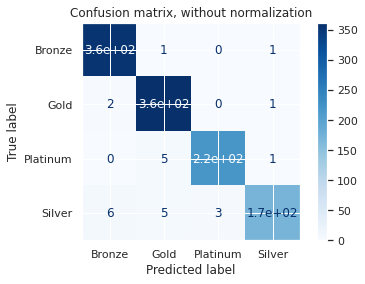

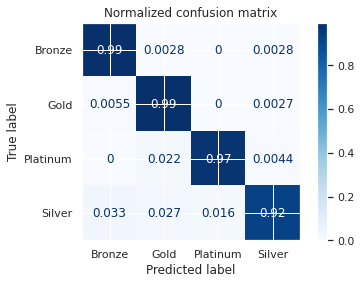


Support Vector Machine
------------------------------
Best params: {'C': 10.0, 'loss': 'squared_hinge', 'penalty': 'l1'} 

Precision: 97.00 % 

Confusion matrix, without normalization
[[357   0   0   1]
 [  6 350   1   8]
 [  0   4 220   1]
 [  6   1   6 171]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.02 0.96 0.   0.02]
 [0.   0.02 0.98 0.  ]
 [0.03 0.01 0.03 0.93]]


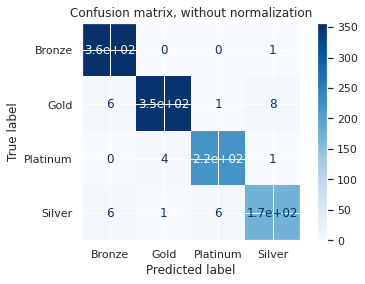

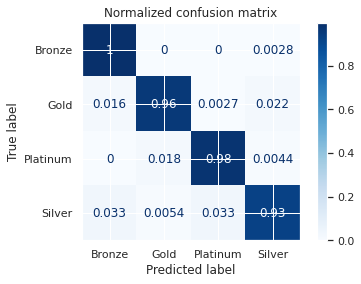


Random Forrest
------------------------------
Best params: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100} 

Precision: 97.00 % 

Confusion matrix, without normalization
[[352   1   0   5]
 [  2 356   4   3]
 [  0   7 217   1]
 [  3   1   3 177]]
Normalized confusion matrix
[[0.98 0.   0.   0.01]
 [0.01 0.98 0.01 0.01]
 [0.   0.03 0.96 0.  ]
 [0.02 0.01 0.02 0.96]]


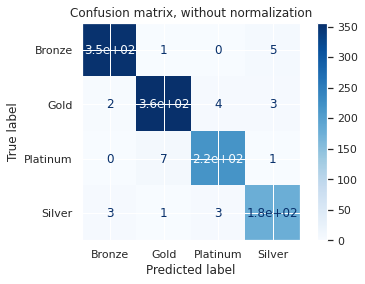

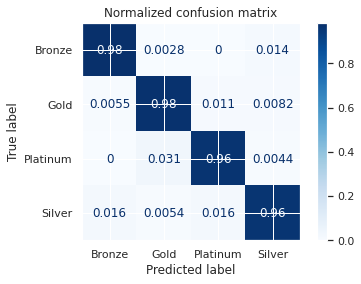


AdaBoost
------------------------------
Best params: {'n_estimators': 20} 

Precision: 73.00 % 

Confusion matrix, without normalization
[[294  63   0   1]
 [ 15 310  40   0]
 [  1  30 194   0]
 [ 34   0 123  27]]
Normalized confusion matrix
[[0.82 0.18 0.   0.  ]
 [0.04 0.85 0.11 0.  ]
 [0.   0.13 0.86 0.  ]
 [0.18 0.   0.67 0.15]]


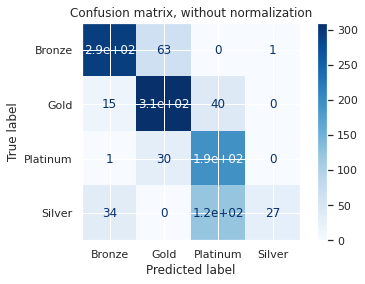

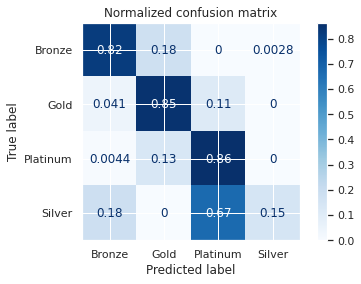


Gradient Boosting
------------------------------
Best params: {'n_estimators': 100} 

Precision: 98.00 % 

Confusion matrix, without normalization
[[354   1   0   3]
 [  3 359   1   2]
 [  0   4 217   4]
 [  1   2   0 181]]
Normalized confusion matrix
[[0.99 0.   0.   0.01]
 [0.01 0.98 0.   0.01]
 [0.   0.02 0.96 0.02]
 [0.01 0.01 0.   0.98]]


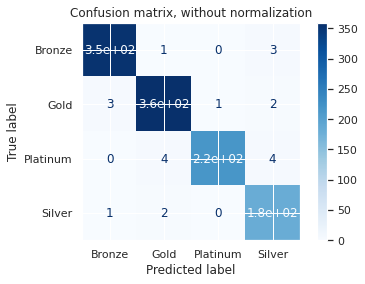

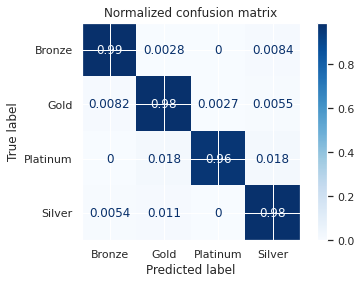

In [17]:
dict_precision = {}

for k, v in DICT_CLF.items():
    print('{}\n{}\n{}'.format('='*30, v['name'], '-'*30))
    dict_precision[v['name']] = {}

    clf = v['clf']
    gs = GridSearchCV(clf, v['params'], cv=5, scoring = 'accuracy',n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_precision[v['name']]['clf'] = gs

    y_pred = gs.predict(X_test_scaled)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision[v['name']]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                             # display_labels=class_names,
                                             cmap=plt.cm.Blues, \
                                             normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    plt.show()
    print()

In [18]:
for k, v in sorted(dict_precision.items(), key=lambda x: x[1]['precision'], reverse=True):
    print("{}: {}".format(k, v['precision']))

k-Nearest Neighbors: 98.0
Gradient Boosting: 98.0
Support Vector Machine: 97.0
Random Forrest: 97.0
AdaBoost: 73.0


# Classification sur des populations différentes
Les jeux de d'entrainement et de test représentent les périodes resp. de Janv.-Août 2011 et Sept.-Nov. 2011

In [19]:
train = source[(source.InvoiceDate >= '2011-01-01') & \
               (source.InvoiceDate < '2011-08-31')].copy()
test = source[(source.InvoiceDate >= '2011-09-01') & \
              (source.InvoiceDate < '2011-12-01')].copy()
train.shape, test.shape

((196559, 9), (118822, 9))

In [20]:
train = preprocess_RFM(train)
X_train = train[['recency', 'frequency', 'monetary_value']]

test = preprocess_RFM(test)
X_test = test[['recency', 'frequency', 'monetary_value']]

std_scale = preprocessing.StandardScaler().fit(np.log(X_train))
X_train_scaled = std_scale.transform(np.log(X_train))
X_test_scaled = std_scale.transform(np.log(X_test))

pca = decomposition.PCA(n_components=2)
X_trans = pca.fit_transform(X_train_scaled)

Silhouette Coefficient: 0.312


cluster
0          1050
1           962
3           543
2           479
dtype: int64

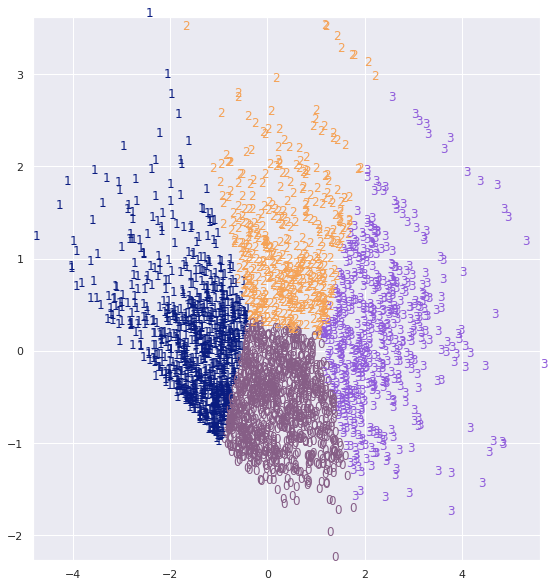

In [21]:
fig = plt.figure(figsize=(20, 10))

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_train_scaled)

plt.subplot(121)
# Puis on visualise, selon la méthode donnée dans le coup de pouce:
for i in range(X_trans.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
             color=color[myclust.labels_[i]] )
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.min(X_trans[:, 0]), np.max(X_trans[:, 0]))
plt.ylim(np.min(X_trans[:, 1]), np.max(X_trans[:, 1]))

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_scaled, myclust.labels_))

pd.DataFrame(myclust.labels_, columns=['cluster']).value_counts()

In [22]:
#Create a cluster label column in the original DataFrame
y_train = myclust.labels_
y_test = myclust.predict(X_test_scaled)

#Calculate average RFM values and size for each cluster:
temp = rfmTable[['recency', 'frequency', 'monetary_value']].\
       merge(X_train.assign(cluster = y_train)['cluster'], \
             left_index=True, right_index=True).\
             groupby(['cluster']).agg(['mean', 'min', 'max']).round(2).\
       sort_values(by=[('monetary_value', 'mean')], \
                   ascending=[False]).round(2).reset_index()
temp

cluster recency          frequency           monetary_value                 
             mean min  max      mean min   max           mean    min       max
0       3  101.08   1  333     93.09   1  5095        1717.63   3.75  62959.36
1       0   84.40   1  333     81.59   1  2356        1612.76   6.20  55231.28
2       1   92.34   1  333     79.37   1  1360        1512.83   2.90  47347.41
3       2   87.43   1  333     80.74   1  1038        1362.91  15.00  32634.18

Etiquetage des clusters calculés

In [23]:
# Transformation des clusters calculés en ranking
dict_rank =  { j: SEGMENTS[i] for i, j in temp['cluster'].to_dict().items()}
print(dict_rank)

y_train_lbl = []
y_test_lbl = []
for i in range(len(y_train)):
    y_train_lbl.append(dict_rank[y_train[i]])
y_train = y_train_lbl
for i in range(len(y_test)):
    y_test_lbl.append(dict_rank[y_test[i]])
y_test = y_test_lbl

{3: 'Platinum', 0: 'Gold', 1: 'Silver', 2: 'Bronze'}


### Classification

k-Nearest Neighbors
------------------------------
Best params: {'n_neighbors': 10} 

Precision: 96.00 % 

Confusion matrix, without normalization
[[1028   13   13   16]
 [   4  426    4    2]
 [  18    0  380    0]
 [  11   13    0  458]]
Normalized confusion matrix
[[0.96 0.01 0.01 0.01]
 [0.01 0.98 0.01 0.  ]
 [0.05 0.   0.95 0.  ]
 [0.02 0.03 0.   0.95]]


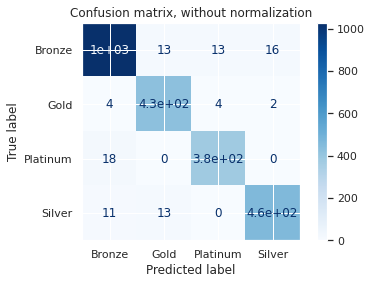

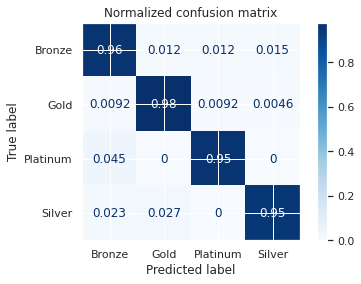


Support Vector Machine
------------------------------
Best params: {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l1'} 

Precision: 94.00 % 

Confusion matrix, without normalization
[[957  16  31  66]
 [  7 428   1   0]
 [  4   8 386   0]
 [  5   3   0 474]]
Normalized confusion matrix
[[0.89 0.01 0.03 0.06]
 [0.02 0.98 0.   0.  ]
 [0.01 0.02 0.97 0.  ]
 [0.01 0.01 0.   0.98]]


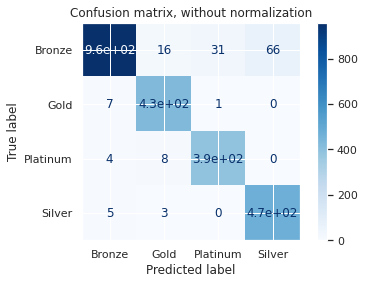

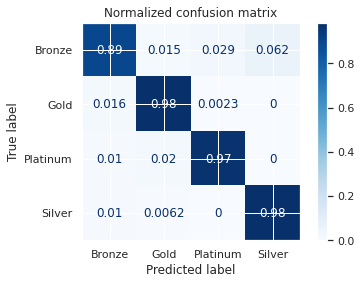


Random Forrest
------------------------------
Best params: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 60} 

Precision: 95.00 % 

Confusion matrix, without normalization
[[1034   10    3   23]
 [   9  412    8    7]
 [  21    0  377    0]
 [  24    5    0  453]]
Normalized confusion matrix
[[0.97 0.01 0.   0.02]
 [0.02 0.94 0.02 0.02]
 [0.05 0.   0.95 0.  ]
 [0.05 0.01 0.   0.94]]


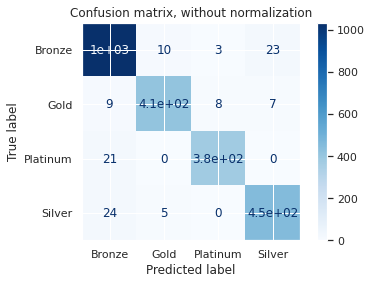

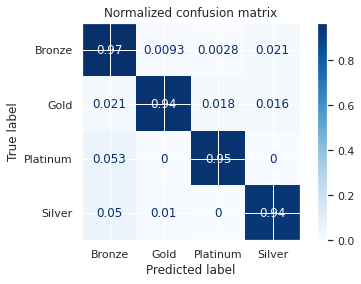


AdaBoost
------------------------------
Best params: {'n_estimators': 10} 

Precision: 78.00 % 

Confusion matrix, without normalization
[[959  37  11  63]
 [ 36 360   9  31]
 [173   5 220   0]
 [ 81  76   0 325]]
Normalized confusion matrix
[[0.9  0.03 0.01 0.06]
 [0.08 0.83 0.02 0.07]
 [0.43 0.01 0.55 0.  ]
 [0.17 0.16 0.   0.67]]


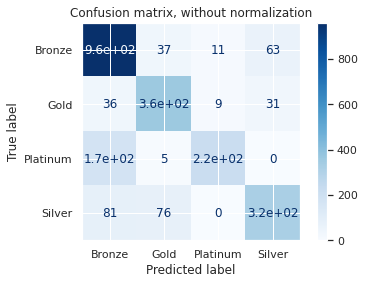

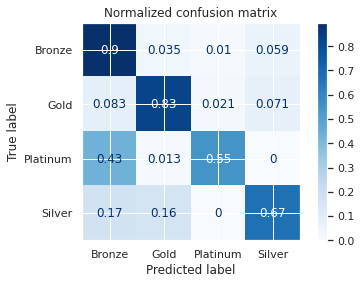


Gradient Boosting
------------------------------
Best params: {'n_estimators': 70} 

Precision: 96.00 % 

Confusion matrix, without normalization
[[1030   11    4   25]
 [   5  414    7   10]
 [  20    0  378    0]
 [  14    2    0  466]]
Normalized confusion matrix
[[0.96 0.01 0.   0.02]
 [0.01 0.95 0.02 0.02]
 [0.05 0.   0.95 0.  ]
 [0.03 0.   0.   0.97]]


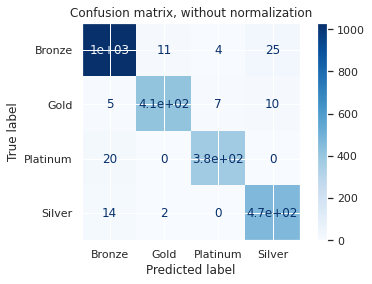

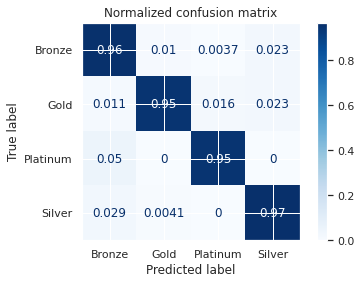

In [24]:
dict_precision2 = {}

for k, v in DICT_CLF.items():
    print('{}\n{}\n{}'.format('='*30, v['name'], '-'*30))
    dict_precision2[v['name']] = {}

    clf = v['clf']
    gs = GridSearchCV(clf, v['params'], cv=5, scoring = 'accuracy',n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_precision2[v['name']]['clf'] = gs

    y_pred = gs.predict(X_test_scaled)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision2[v['name']]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                             # display_labels=class_names,
                                             cmap=plt.cm.Blues, \
                                             normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    plt.show()
    print()

In [25]:
for k, v in sorted(dict_precision2.items(), key=lambda x: x[1]['precision'], reverse=True):
    print("{}: {}".format(k, v['precision']))

k-Nearest Neighbors: 96.0
Gradient Boosting: 96.0
Random Forrest: 95.0
Support Vector Machine: 94.0
AdaBoost: 78.0


In [26]:
with open('OC_DS_P5.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(dict_precision['k-Nearest Neighbors']['clf'])

# Fonction

In [27]:
segment_customers(source)

,CustomerID,recency,frequency,monetary_value,Segment
0,12747,14,88,3489.74,Platinum
1,12748,1,3684,25375.92,Platinum
2,12749,14,198,3869.55,Platinum
3,12820,36,59,942.34,Gold
4,12821,87,6,92.72,Bronze
...,...,...,...,...,...
3766,18278,65,9,173.90,Bronze
3767,18280,151,10,180.60,Bronze
3768,18282,207,12,176.60,Bronze
3769,18283,1,719,2039.58,Platinum
